## Reloading data from previous exercice. Please enter the proper path to exercice as the example below

| Date                |   Copper |   Aluminum |   Zinc |   Lead |   Tin |   Oil Futures |
|:--------------------|---------:|-----------:|-------:|-------:|------:|--------------:|
| 2010-01-01 00:00:00 |     7375 |       2230 |   2560 | 2432   | 16950 |         79.36 |
| 2010-01-04 00:00:00 |     7500 |       2267 |   2574 | 2515   | 17450 |         81.51 |
| 2010-01-05 00:00:00 |     7485 |       2302 |   2575 | 2522.5 | 17375 |         81.77 |
| 2010-01-06 00:00:00 |     7660 |       2377 |   2718 | 2680   | 17825 |         83.18 |
| 2010-01-07 00:00:00 |     7535 |       2310 |   2607 | 2599   | 17475 |         82.66 |
| Date                |   Copper |   Aluminum |   Zinc |   Lead |   Tin |   Oil Futures |
|:--------------------|---------:|-----------:|-------:|-------:|------:|--------------:|
| 2021-01-01 00:00:00 |     7766 |     1979.5 |   2751 |   1994 | 20325 |         48.52 |
| Date                |   Copper |   Aluminum |   Zinc |   Lead |   Tin |   Oil Futures |
|:--------

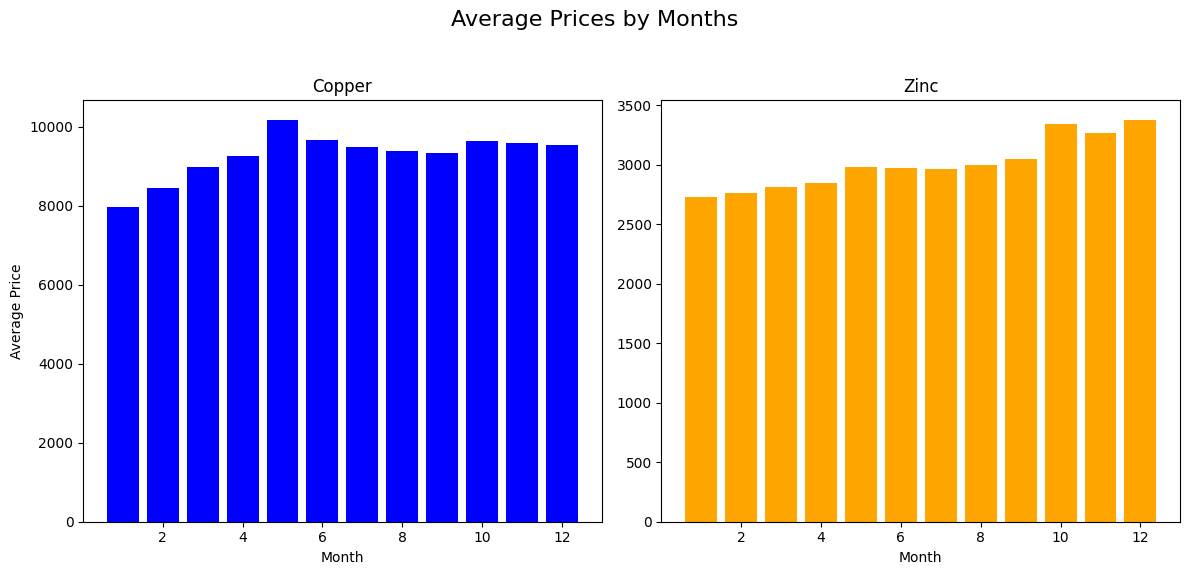

In [1]:
%run "/Users/rayannitcheu/Documents/GitHub/OilDesk-Intern-Assessment/solutions/exercice_2.ipynb"

In [2]:
import sqlite3

from sqlalchemy import inspect

In [3]:
def calculate_rsi(p,
                  commodities_names, 
                  window=14):
    """
    This function calculates the RSI for a given df of commodity prices and returns the original df along with the RSI values.
    """
    res = p.copy()

    for c in commodities_names:

        # Compute the price delta
        delta = p[c].diff()

        # Compute the rolling mean of gains and losses on the given window 
        avg_gain = delta.where(delta > 0, 0).rolling(window=window).mean()
        avg_loss = -delta.where(delta < 0, 0).rolling(window=window).mean()

        # Compute the RSI
        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))

        # Store the RSI
        res[f"{c}-RSI"] = rsi

    return res


def calculate_macd(p, 
                   commodities_names, 
                   short_window=12,
                   long_window=26,
                   signal_window=9):
    """
    This function calculates the RSI for a given df of commodity prices and returns the original df along with the RSI values.
    """
    res = p.copy()

    for c in commodities_names:
        # Compute the short term EMA
        ema_short = p[c].ewm(span=short_window, adjust=False).mean()

        # Compute the long term EMA
        ema_long = p[c].ewm(span=long_window, adjust=False).mean()

        # Compute the MACD indicator
        macd_line = ema_short - ema_long

        # Compute the MACD signal
        signal_line = macd_line.ewm(span=signal_window, adjust=False).mean()

        # Compute the histogram 
        macd_histogram = macd_line - signal_line

        # Store the results
        res[f'{c}-MACD'] = macd_line
        res[f'{c}-SIGNAL'] = signal_line
        res[f'{c}-HISTOGRAM'] = macd_histogram

    return res

@log_operation
def add_non_existing_columns():
    """
    This function will be used to add the non existing columns for the RSI and MACD.
    """
    # Extracting existing columns names in the table
    inspector = inspect(engine)
    existing_columns = [column['name'] for column in inspector.get_columns('commodity_prices')]
    
    # If our columns are not already present we add them to the table. We cannot modify existing table using the session object
    with sqlite3.connect('commodities_prices.db') as conn:
        cursor = conn.cursor()
        if 'rsi' not in existing_columns:
            cursor.execute("ALTER TABLE commodity_prices ADD COLUMN rsi FLOAT")

        if 'macd' not in existing_columns:
            cursor.execute("ALTER TABLE commodity_prices ADD COLUMN macd FLOAT")

        conn.commit()


@log_operation
def update_indicators(data, indicator):
    """
    This function is used to update the existing records by adding the indicators values. 
    """
    with session_scope() as session:
        if isinstance(data, list):
            for d in data:
                record = session.query(CommodityTable).filter_by(date=d.get("Date"), commodity=d.get("Commodity")).first()
                if record:
                    if "RSI" in indicator:
                        record.rsi = d.get(indicator)

                    if "MACD" in indicator:
                        record.macd = d.get(indicator)
       
        else:
            record = session.query(CommodityTable).filter_by(date=data.get("Date"), commodity=data.get("Commodity")).first()
            if record:
                if indicator == "RSI":
                    record.rsi = data.get(indicator)

                if indicator == "MACD":
                    record.macd = data.get(indicator)

In [4]:
start = dt(2020, 1, 1)
end = dt(2021, 12, 31)
commodities_list = ["Zinc", "Copper"]
filtered_data = filter_by_dates(clean_data, start, end)[commodities_list]

In [5]:
pretty_print(filtered_data.head())

| Date                |   Zinc |   Copper |
|:--------------------|-------:|---------:|
| 2020-01-01 00:00:00 | 2272   |   6174   |
| 2020-01-02 00:00:00 | 2310   |   6188   |
| 2020-01-03 00:00:00 | 2306   |   6129.5 |
| 2020-01-06 00:00:00 | 2324.5 |   6138.5 |
| 2020-01-07 00:00:00 | 2346   |   6149   |


## Changing the existing Scheme for SQL

In [6]:
class CommodityTable(Base):
    __table_args__ = {'extend_existing': True}
    __tablename__ = 'commodity_prices'

    id = Column(Integer, primary_key=True)
    date = Column(Date, nullable=False)
    commodity = Column(String, nullable=False)
    price = Column(Float, nullable=False)
    rsi = Column(Float, nullable=True)
    macd = Column(Float, nullable=True)

In [7]:
add_non_existing_columns()

2024-10-04 20:22:22,210 - INFO - Executing add_non_existing_columns
2024-10-04 20:22:22,212 - INFO - Successfully executed add_non_existing_columns in 0.0011 seconds


## Calculation of the RSI and MACD indicators

We're defining random parameters for the sake of it:

* We're are setting a max window because since both the RSI and MACD are rolling indicators so the values before the was enough data to match the window are not relevant.


In [8]:
rsi_window = 14
short_window = 12
long_window = 26
signal_window = 9
max_window = max([short_window, long_window, signal_window])

In [9]:
data_w_indicators = calculate_macd(filtered_data,
                                   commodities_list,
                                   short_window=short_window, 
                                   long_window=long_window, 
                                   signal_window=signal_window)

data_w_indicators = calculate_rsi(data_w_indicators,
                                  commodities_list, 
                                  window=rsi_window)

for commo in commodities_list:
    df_rsi = data_w_indicators[[f"{commo}-RSI"]].iloc[rsi_window:, :]
    df_rsi.columns = [commo]

    df_macd = data_w_indicators[[f"{commo}-MACD"]].iloc[max_window:, :]
    df_macd.columns = [commo]

    sql_rsi = convert_df_to_sql(df_rsi, "RSI")
    sql_macd = convert_df_to_sql(df_macd, "MACD")

    update_indicators(sql_rsi, "RSI")
    update_indicators(sql_macd, "MACD")

2024-10-04 20:22:22,227 - INFO - Executing update_indicators
2024-10-04 20:22:22,596 - INFO - Successfully executed update_indicators in 0.3680 seconds
2024-10-04 20:22:22,596 - INFO - Executing update_indicators
2024-10-04 20:22:22,945 - INFO - Successfully executed update_indicators in 0.3487 seconds
2024-10-04 20:22:22,949 - INFO - Executing update_indicators
2024-10-04 20:22:23,124 - INFO - Successfully executed update_indicators in 0.1750 seconds
2024-10-04 20:22:23,124 - INFO - Executing update_indicators
2024-10-04 20:22:23,290 - INFO - Successfully executed update_indicators in 0.1661 seconds
